In [15]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

In [16]:
# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import sys
# caffe_root = '../'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, 'python')

import caffe
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

In [17]:
import os
if os.path.isfile('models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'):
    print 'CaffeNet found.'
else:
    print 'Downloading pre-trained CaffeNet model...'
    !../scripts/download_model_binary.py ../models/bvlc_reference_caffenet

CaffeNet found.


In [18]:
caffe.set_mode_cpu()

model_def = 'models/bvlc_reference_caffenet/deploy.prototxt'
model_weights = 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

In [19]:
# load the mean ImageNet image (as distributed with Caffe) for subtraction
mu = np.load('python1/caffe/imagenet/ilsvrc_2012_mean.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print 'mean-subtracted values:', zip('BGR', mu)

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]


In [27]:
# set the size of the input (we can skip this if we're happy
#  with the default; we can also change it later, e.g., for different batch sizes)
net.blobs['data'].reshape(1,        # batch size
                          3,         # 3-channel (BGR) images
                          227, 227)  # image size is 227x227

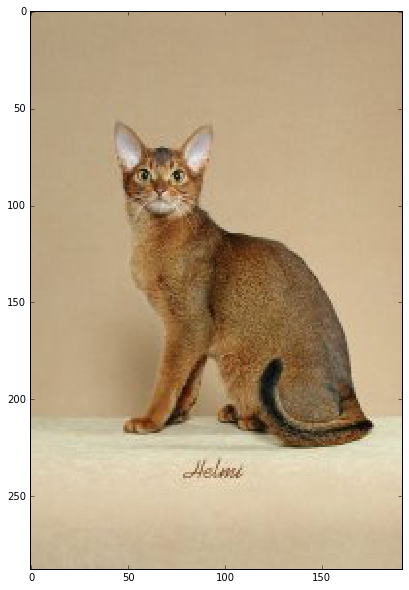

In [28]:
image = caffe.io.load_image('images/Abyssinian_11.jpg')
transformed_image = transformer.preprocess('data', image)
plt.imshow(image)

In [29]:
# copy the image data into the memory allocated for the net
net.blobs['data'].data[...] = transformed_image

### perform classification
output = net.forward()

output_prob = output['prob'][0]  # the output probability vector for the first image in the batch

print 'predicted class is:', output_prob.argmax()

predicted class is: 277


In [30]:
# load ImageNet labels
labels_file = 'data/ilsvrc12/synset_words.txt'
if not os.path.exists(labels_file):
    !data/ilsvrc12/get_ilsvrc_aux.sh
    
labels = np.loadtxt(labels_file, str, delimiter='\t')

print 'output label:', labels[output_prob.argmax()]

output label: n02119022 red fox, Vulpes vulpes


In [31]:
# sort top five predictions from softmax output
top_inds = output_prob.argsort()[::-1][:5]  # reverse sort and take five largest items

print 'probabilities and labels:'
zip(output_prob[top_inds], labels[top_inds])

probabilities and labels:


[(0.36019295, 'n02119022 red fox, Vulpes vulpes'),
 (0.16050522, 'n02120505 grey fox, gray fox, Urocyon cinereoargenteus'),
 (0.1501489, 'n02441942 weasel'),
 (0.12634523, 'n02119789 kit fox, Vulpes macrotis'),
 (0.052251581, 'n02120079 Arctic fox, white fox, Alopex lagopus')]

In [32]:
# for each layer, show the output shape
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

data	(1, 3, 227, 227)
conv1	(1, 96, 55, 55)
pool1	(1, 96, 27, 27)
norm1	(1, 96, 27, 27)
conv2	(1, 256, 27, 27)
pool2	(1, 256, 13, 13)
norm2	(1, 256, 13, 13)
conv3	(1, 384, 13, 13)
conv4	(1, 384, 13, 13)
conv5	(1, 256, 13, 13)
pool5	(1, 256, 6, 6)
fc6	(1, 4096)
fc7	(1, 4096)
fc8	(1, 1000)
prob	(1, 1000)


In [33]:
for layer_name, param in net.params.iteritems():
    print layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape)

conv1	(96, 3, 11, 11) (96,)
conv2	(256, 48, 5, 5) (256,)
conv3	(384, 256, 3, 3) (384,)
conv4	(384, 192, 3, 3) (384,)
conv5	(256, 192, 3, 3) (256,)
fc6	(4096, 9216) (4096,)
fc7	(4096, 4096) (4096,)
fc8	(1000, 4096) (1000,)


In [34]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

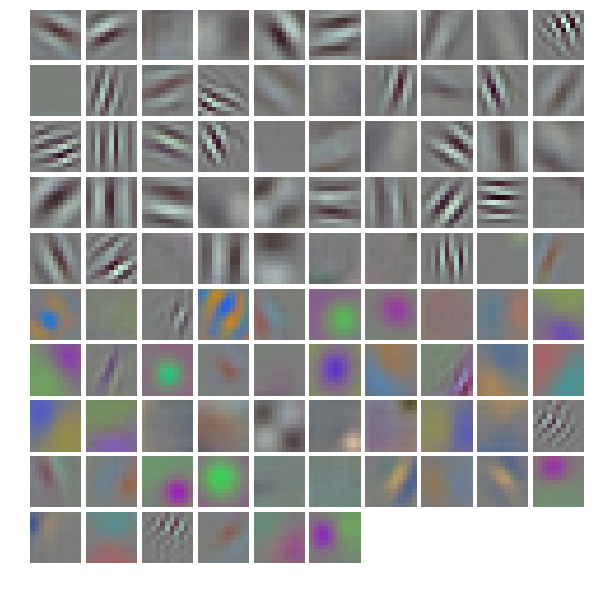

In [35]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

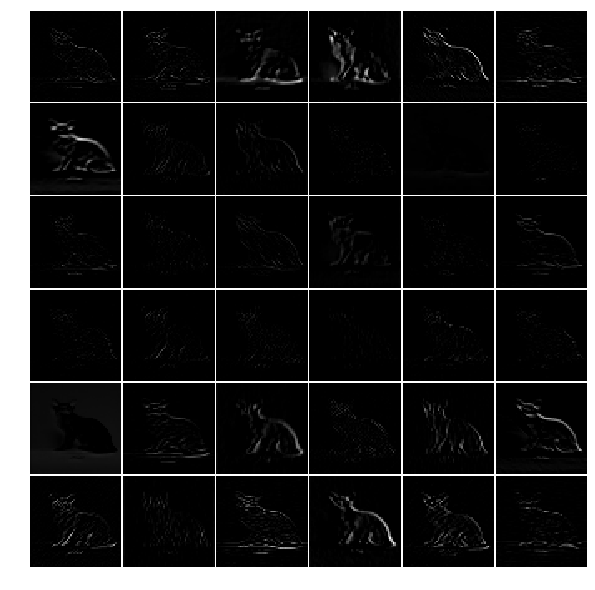

In [36]:
feat = net.blobs['conv1'].data[0, :36]
vis_square(feat)

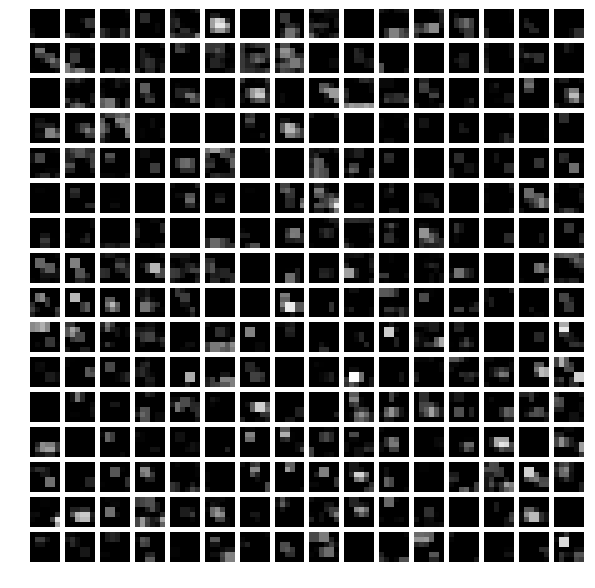

In [37]:
feat = net.blobs['pool5'].data[0]
vis_square(feat)

In [38]:
net.blobs['fc6'].data.shape

(1, 4096)

In [39]:
np.savetxt("fc6.csv", net.blobs['fc6'].data, delimiter=",")

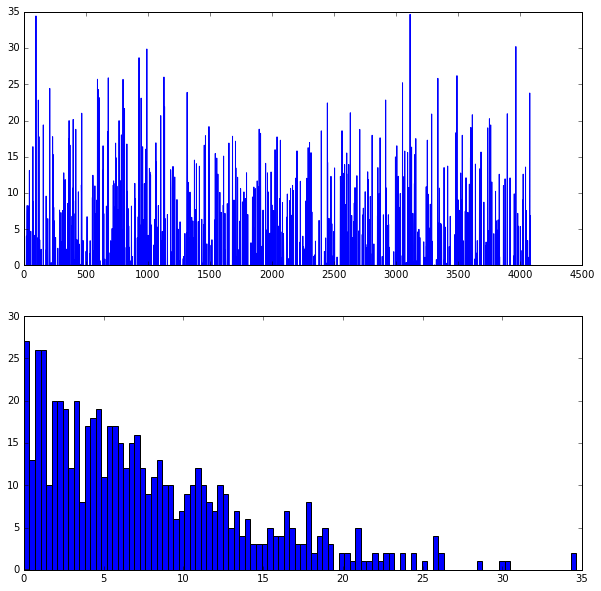

In [40]:
feat = net.blobs['fc6'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

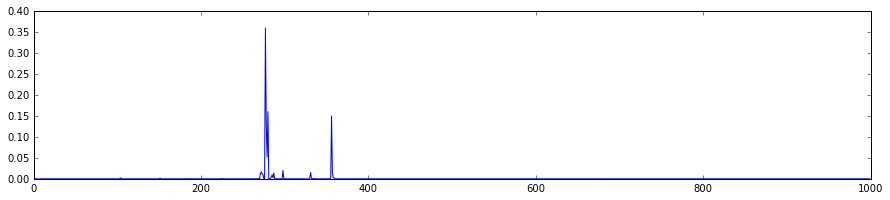

In [41]:
feat = net.blobs['prob'].data[0]
plt.figure(figsize=(15, 3))
plt.plot(feat.flat)

probabilities and labels:


[(0.36019295, 'n02119022 red fox, Vulpes vulpes'),
 (0.16050522, 'n02120505 grey fox, gray fox, Urocyon cinereoargenteus'),
 (0.1501489, 'n02441942 weasel'),
 (0.12634523, 'n02119789 kit fox, Vulpes macrotis'),
 (0.052251581, 'n02120079 Arctic fox, white fox, Alopex lagopus')]

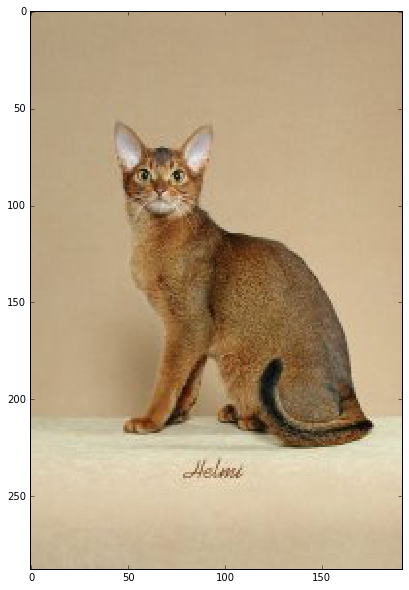

In [42]:
# download an image
#my_image_url = caffe.io.load_image('images/Abyssinian_11.jpg')  # paste your URL here
# for example:
# my_image_url = "https://upload.wikimedia.org/wikipedia/commons/b/be/Orang_Utan%2C_Semenggok_Forest_Reserve%2C_Sarawak%2C_Borneo%2C_Malaysia.JPG"
#!wget -O image.jpg $my_image_url

# transform it and copy it into the net
image = caffe.io.load_image('images/Abyssinian_11.jpg')
net.blobs['data'].data[...] = transformer.preprocess('data', image)

# perform classification
net.forward()

# obtain the output probabilities
output_prob = net.blobs['prob'].data[0]

# sort top five predictions from softmax output
top_inds = output_prob.argsort()[::-1][:5]

plt.imshow(image)

print 'probabilities and labels:'
zip(output_prob[top_inds], labels[top_inds])

In [43]:
from glob import glob
from os import path

def get_files_in(folder, pattern='*.txt'):
    return glob(path.join(folder, pattern))

def filenames(folder):
    filename = get_files_in(folder, '*.jpg')
    #filename1 = get_files_in(folder, '*.mat')
    #for i in range(len(filename)):
        #filename.append(filename1[i])
    return filename

In [44]:
dic_dir = filenames('images')

In [8]:
dic_dir[1].split('/')[1][0]

'A'

In [21]:
def image_lable(file_dir):
    img_dir = filenames(file_dir)
    lable = []
    img_name = []
    for i in range(len(img_dir)):
        image = caffe.io.load_image(img_dir[i])
        if image == None:
            continue
        img_name.append(img_dir[i])
        if img_dir[i].split("/")[1][0].isupper() == True:
            lable.append(0) # 0 means cat
        else:
            lable.append(1) # dog
            
    return np.array(img_name), np.array(lable)

In [22]:
df_x, df_y = image_lable('images')

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [23]:
from sklearn import cross_validation

In [24]:
X_train_name, X_test_name, Y_train, Y_test = cross_validation.train_test_split(df_x, df_y, test_size = 0.70, random_state = 10)

In [25]:
X_train_name

array(['images/english_cocker_spaniel_87.jpg', 'images/newfoundland_2.jpg',
       'images/english_cocker_spaniel_155.jpg', ...,
       'images/Persian_123.jpg', 'images/yorkshire_terrier_192.jpg',
       'images/Birman_18.jpg'], 
      dtype='|S41')

In [ ]:
i = 0
image = caffe.io.load_image(X_train_name[0])
net.blobs['data'].data[...] = transformer.preprocess('data', image)
feature = np.array(net.blobs['fc7'].data[0])
for name in X_train_name[1:]:
    image = caffe.io.load_image(name)
    net.blobs['data'].data[...] = transformer.preprocess('data', image)
    feature = np.vstack([feature,(np.array(net.blobs['fc7'].data[0]))])
    i += 1
    print i

# perform classification
    #net.forward()

# obtain the output probabilities
    #output_prob = net.blobs['prob'].data[0]

# sort top five predictions from softmax output
#top_inds = output_prob.argsort()[::-1][:5]

#plt.imshow(image)

#print 'probabilities and labels:'
#zip(output_prob[top_inds], labels[top_inds])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [ ]:
print feature.shape, Y_train.shape

In [180]:
print len(feature), len(Y_train)

2217 2217


In [181]:
from sklearn import linear_model, svm, metrics, datasets

In [182]:
svm = svm.LinearSVC()
svm.fit(feature, Y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [191]:
log = linear_model.LogisticRegressionCV(cv = 5, Cs = 3)
log.fit(feature, Y_train)

LogisticRegressionCV(Cs=3, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [189]:
pac = linear_model.PassiveAggressiveClassifier(C = 0.1)
pac.fit(feature, Y_train)

PassiveAggressiveClassifier(C=0.1, class_weight=None, fit_intercept=True,
              loss='hinge', n_iter=5, n_jobs=1, random_state=None,
              shuffle=True, verbose=0, warm_start=False)

In [195]:
sgd = linear_model.SGDClassifier(alpha = 0.01)
sgd.fit(feature, Y_train)

SGDClassifier(alpha=0.01, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [196]:
print metrics.classification_report(Y_train, sgd.predict(feature)), metrics.classification_report(Y_train, log.predict(feature))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       731
          1       0.67      1.00      0.80      1486

avg / total       0.45      0.67      0.54      2217
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       731
          1       0.67      1.00      0.80      1486

avg / total       0.45      0.67      0.54      2217

